# Gaussian Process Regression

This demo shows how to use the GaussianProcessRegressor class to calculate the efficiency of three-jet events with MET < 50 GeV.

The following nuisance parameters are considered:
- $\nu_{J1}$: Jet energy scale of the leading jet, $J_1$.
- $\nu_{J23}$: Jet energy scale of the two softer jets, $J_2$ and $J_3$.

In [1]:
# Imports
from multiprocessing import Pool, cpu_count

import numpy as np

import gpder
from gpder.gaussian_process import GaussianProcessRegressor
from gpder.gaussian_process.kernels import RegularKernel

In [2]:
from utils import download_dataset, load_dataset

# Downloading the dataset from zenodo.
# By default, the h5df file is saved in the current directory.
download_dataset()
threeM = load_dataset()

# The dataset consists of 30000 events, each with three jets.
# For each jet, the three-momenta (pT, eta, phi) are saved in descending pT-order.
print("Shape of the dataset:", threeM.shape)

Shape of the dataset: (30000, 3, 3)


In [3]:
# Plotting function
from utils import plot_regression

# Function that calculates the efficiency with respect to the two nuisance
# See hep_functions.py for more details
from hep_functions import efficiency


def efficiency_events(X, threeM=threeM):
    # Simplifying the input
    return efficiency(X, threeM)

In [4]:
# -- Test dataset ---------------------------------------------------------- #
res_test = 25
X_lower, X_upper = 0.5, 1.5
lin = np.linspace(X_lower, X_upper, res_test)
nu_J1_test, nu_J23_test = np.meshgrid(lin, lin)
X_test = np.array([nu_J1_test.flatten(), nu_J23_test.flatten()]).T
y_test = Pool(cpu_count()).map(efficiency_events, X_test)
y_test = np.array(y_test)
# -------------------------------------------------------------------------- #

# -- Training dataset ------------------------------------------------------ #
nu_J1_train = [0.74, 1.0, 1.0, 1.0, 1.25]
nu_J23_train = [1.0, 0.75, 1.0, 1.25, 1.0]
X_train = np.array([nu_J1_train, nu_J23_train]).T
y_train = Pool(cpu_count()).map(efficiency_events, X_train)
y_train = np.array(y_train)
# -------------------------------------------------------------------------- #

Kernel before optimization: 
1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1)

Kernel after optimization: 
0.519**2 * RBF(length_scale=0.233) + WhiteKernel(noise_level=0.01)

Evaluation 
MSE:  0.13024460936739576
Total variance:  78.97220868055311


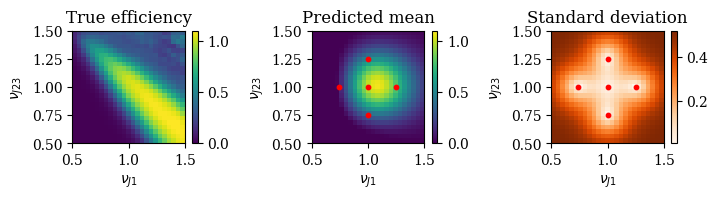

In [5]:
# -- Fitting the model and hyperparameter optimization --------------------- #
kernel = RegularKernel(amplitude=1.0, length_scale=0.1, noise_level=0.1)
print("Kernel before optimization: ")
print(kernel)
# Set optimizer=None to skip hyperparameter optimization
gp = GaussianProcessRegressor(
    kernel=kernel, optimizer="L-BFGS-B", n_restarts_optimizer=10, random_state=42
)
gp.fit(X_train, y_train)
print("\nKernel after optimization: ")
print(gp.kernel)
# -------------------------------------------------------------------------- #

# -- Prediction and eval --------------------------------------------------- #
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)

print("\nEvaluation ")
mse = np.sum((y_test - y_pred_mean.ravel()) ** 2) / len(y_test)
print("MSE: ", mse)
print("Total variance: ", np.sum(y_pred_std**2))
# -------------------------------------------------------------------------- #

plot_regression(gp, X_test, y_test)